In [9]:
from __future__ import print_function, division, unicode_literals
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [10]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

class RewardNet(nn.Module):
    def __init__(
        self, state_dim, output_mod=None):
        super().__init__()
        self.reward = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.pref = nn.Linear(2, 1)
        self.apply(weight_init)

    def forward(self, state1, state2):
        r1 = self.reward(state1)
        r2 = self.reward(state2)
        comp = torch.squeeze(torch.stack([r1,r2], dim=1))
        pref = self.pref(comp)
        return r1, r2, pref

In [11]:
state_dim = 18

reward_net = RewardNet(state_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reward_net.to(device)

RewardNet(
  (reward): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (pref): Linear(in_features=2, out_features=1, bias=True)
)

In [12]:
import csv
with open('data/train_rewards10.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

[1,     1] loss: 0.66004992
[2,     1] loss: 0.65259349
[3,     1] loss: 0.64532340
[4,     1] loss: 0.63816702
[5,     1] loss: 0.63115084
[6,     1] loss: 0.62429190
[7,     1] loss: 0.61756748
[8,     1] loss: 0.61098850
[9,     1] loss: 0.60451567
[10,     1] loss: 0.59818625
[11,     1] loss: 0.59195316
[12,     1] loss: 0.58577091
[13,     1] loss: 0.57968396
[14,     1] loss: 0.57371593
[15,     1] loss: 0.56780440
[16,     1] loss: 0.56192696
[17,     1] loss: 0.55603439
[18,     1] loss: 0.55015862
[19,     1] loss: 0.54432166
[20,     1] loss: 0.53846997
[21,     1] loss: 0.53262758
[22,     1] loss: 0.52675045
[23,     1] loss: 0.52082962
[24,     1] loss: 0.51490206
[25,     1] loss: 0.50896841
[26,     1] loss: 0.50304389
[27,     1] loss: 0.49708194
[28,     1] loss: 0.49109301
[29,     1] loss: 0.48502356
[30,     1] loss: 0.47891769
[31,     1] loss: 0.47277051
[32,     1] loss: 0.46661115
[33,     1] loss: 0.46041474
[34,     1] loss: 0.45423809
[35,     1] loss: 0.448

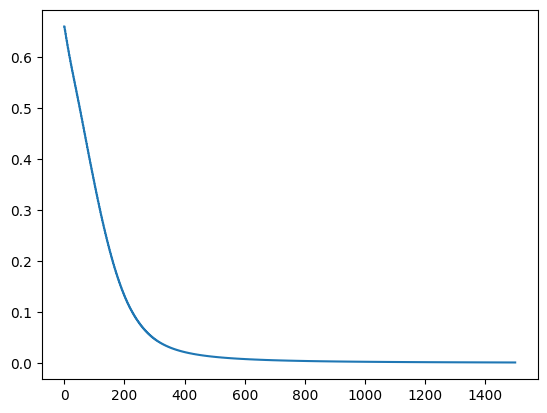

In [13]:
num_epochs = 750
batch_size = 10

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(reward_net.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(states1)))
num_batches = len(idxs) // batch_size

# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
   
        t_states1 = torch.Tensor(states1).float().to(device)
        t_states2 = torch.Tensor(states2).float().to(device)
        t_prefs = torch.Tensor(prefs).float().to(device).unsqueeze(1)

        pred_r1s, pred_r2s, pred_prefs = reward_net(t_states1, t_states2)
        loss = criterion(pred_prefs, t_prefs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

torch.save(reward_net, 'reward_network.pt')
print('Finished Training')
plt.plot(losses)
plt.savefig('losses.png')

In [14]:
reward_net = torch.load('reward_network.pt')
reward_net.eval()

import csv
with open('data/test_rewards.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

num_correct = 0.0
for i in range(len(states1)):
    state1 = torch.Tensor(states1[i]).to(device)
    state2 = torch.Tensor(states2[i]).to(device)
    pred_r1, pred_r2, pred_pref = reward_net(state1, state2)
    pred_r1 = torch.sigmoid(pred_r1)
    pred_r2 = torch.sigmoid(pred_r2)
    pred_pref = torch.sigmoid(pred_pref).cpu().detach().numpy()[0]
    if pred_pref > 0.5 and prefs[i] == 1:
        num_correct+=1
    elif pred_pref <= 0.5 and prefs[i] == 0:
        num_correct+=1

accuracy = num_correct / len(states1)
print("Percent correct: %f " % accuracy)

Percent correct: 0.640000 


In [15]:
print(pred_r1)
print(pred_r2)
print(pred_pref)

tensor([0.9600], grad_fn=<SigmoidBackward0>)
tensor([0.6802], grad_fn=<SigmoidBackward0>)
0.9787617


In [8]:
best_mushroom = torch.Tensor(np.array([1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0])).to(device)
pred_r1, pred_r2, pred_pref = reward_net(best_mushroom,best_mushroom)
print(torch.sigmoid(pred_r1))
print(torch.sigmoid(pred_r2))
print(torch.sigmoid(pred_pref))

tensor([0.0122], grad_fn=<SigmoidBackward0>)
tensor([0.0122], grad_fn=<SigmoidBackward0>)
tensor([0.9998], grad_fn=<SigmoidBackward0>)
